In [1]:
#Bowerbird null model (all males are guarders)

#Key
#Notes- Paramters contain underscores, while functions don't
#SB: Stay at bower
#FG: Foraging
#MT: Maraud travel (travel to rival's bower)
#MA: Maraud action (destroy bower if absent, have antagonistic interaction in present)
#MR: Maraud return (return to own bower)
#RB: Repair own bower
#MT_vs_FG: the probability of next transition away from SB being to MT (otherwise it would be to FG)
#a=-1: denotes a staying at bower action on ticket
#a=-2: denotes a foraging action on ticket
#a=-3: denotes a female visiting action on a ticket
#a=-4: denotes travel to another male's bower
#a=-5: denotes marauding of another male's bower
#a=-6: denotes returning from another male's bower
#a=-7: denotes a bower repair action on a ticket
#target: the male/node an action is preformed on. For maurading, the target is the bird under potential attack. For mating, target is male being mated with. For other activities other then maurading and mating, owner and target are the same.
#owner: The male or female actively performing an action. For mating, the female is the owner. For all other activities, the owner is male.
#networkwriter: generates network where everybird is connected
#addtotimeline: adds tickets to timeline
#travel_times_linear_p: generates a matrix that contains the probabilities of travelling to a given a bower 
#if the relationship between distance and travel preference is linear
#improb: The probability of traveling improb_distance or less
#improb_distance: The distance at which there is only a (1-improb)% chance of choosing to travel
#lamb: lambda calculated by solving improb=1-numpy.exp(-lamb*improb_distance)
#bower_states: options are 1(bower intact) and 0 (bower destroyed-will never be the case when all guarders)
#male_states: options are [leave_time, leave_action, SB_timeholder] (male present at bower) and 0 (male absent from bower)
#fitness_states: keeps track of number of matings a given male has had
#t: time
#nodes: total number of male bowerbirds in the network
#node_dist: the node by nde matrix with distances between each node
#node_graph: matrix with individuals 1 through nodes numbered by going through each row
#tau: Length of time an activity takes. If a foraging ticket has a tau of 0.5 and occurs at t=1, then the bird is foraging for 30 minutes, at which point a SB activity will start (at t=1.5).
#t_court: the amount of time it takes a female to court+mate with a male, generated from a normal distribution


import math
import random
import numpy as numpy
import matplotlib.pyplot as plt


#Parameters:
t=0.0 #start at time 0
t_max=12#12*4*30 #2 months in hrs (assume no nights so 12 hr = 1 day)
timeholder=0
timeline=[] #initialize the timeline
discards=[] #where we put the old version of tickets that get over-written/moved
#We've moved away from using these params with expovariate (how we handle FV is still TBD)
#So THE BELOW 3 SHOULD BE COMMENTED OUT (but rn we don't want the handler funcs to yell at us)
FV_param=[1, t_max/2] #5days, tmax/3 #0.2 #nodes/0.19 #totally random
FG_param=3 #larger values lead to foraging ending earlier, because taus are smaller
SB_param=1.5 #larger values lead to bowerstay ending earlier, because taus are smaller
RB_param=2 #made up -- takes 30mins (every time -- no distribution) to repair bower
MA_param=.1 #made up -- takes 6mins (every time -- no distribution) to maraud bower
MT_vs_FG=.05 #compared 20 feedings/day to .1 maraudings/hr
nodes=4
bower_states=[1]*nodes
male_states=[0]*nodes #start at foraging now
fitness_states=[0]*nodes
success_rates=1
success_times=[] #going to change this to be a vector of times when the female leaves (at this point, sucessful mating has occured)
recents_list=[]
max_visits=6 #STEEEEVEEEE
bird_speed=12*3600 #m/hr (12m/s)
d=150.0




# makes a ticket
def ticketgenerator(tau,t, o, a, targ):
    ticket={
        'tau': tau,
        'time': t,
        'owner': o,
        'action': a,
        'target': targ
    }
    return ticket;

#writes the edges to a network of n birds where everyone is connected to everyone else 
def networkwriter(n):
    connect=[0]*n
    for i in range(0, n): 
        a=list(range(n)) #generating a list that goes from 0 to n-1
        a.remove(i) #individual removes themselves from the network
        connect[i]=a #corresponds to the list of people person i is linked to
    return connect; #returns a list of lists with all the connections in the network


# function for determining the next time based on our rate parameters
def nexttau(action):
    x=-1
    while x<=0:
        switcher = {
            -1: numpy.random.normal(loc=.1583, scale=.09755, size=1)[0], #choose when to leave bower (generate a tau for bower stay)
            -2: numpy.random.gamma(shape=1.5, scale=5, size=1)[0]/60, #choose when to stop foraging (generate a tau for foraging)
            -3: numpy.random.uniform(FV_param[0], FV_param[1]), #FV_param... totally arbitrary so we should think about it
            -5: MA_param, #in the future we'll do something with it
            -7: RB_param #in the future we'll do something with it 
        }
        x=switcher.get(action)
        return x
    

#adds new tickets to timeline -- Stefano, any more efficient suggestions for keeping timeline in order?
def addtotimeline(tic, timeline):
    if not timeline:
        timeline.append(tic)
    else:
        ind=len(timeline)-1
        end=0
        while (tic['time']<timeline[ind]['time'] and end==0): #moves backwards until it finds where to place the ticket based on the listed times
            ind=ind-1 
            if(ind<0):
                end=1
        ind=ind+1
        timeline.insert(ind, tic)
        
#Stay at bower ticket handler. Ticket is read, and male state changes to at bower. Can generate repair bower, foraging, or maurad travel ticket.
def SBtickethandler(SB_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times):
    ow=SB_tic['owner'] 
    if male_states[ow]!=0.0: #because any male who is at his bower was last repairing his bower (not coming from FG or MR) 
        bower_states[ow]=1
    t=SB_tic['time']
    ta=SB_tic['tau']
    if bower_states[ow]==0: #if male returns to a destroyed bower, must repair it
        RB_tau=nexttau(-7)
        SB_tic['tau']=0
        timeline[timeholder]=SB_tic #change the tau on the timeline (not just SB_tic, a copy)
        future_t=RB_tau+t
        if future_t>t_max:
            RB_tau=RB_tau-(future_t-t_max)   
        tic=ticketgenerator(RB_tau,t,ow,-7,ow) #immediately, RB_tic starts
        addtotimeline(tic,timeline)
        male_states[ow]=[tic['time']+RB_tau, tic['action'], timeholder] #important!!
    else:
        MT_FG_time=ta+t
        if MT_FG_time<t_max:
            decider=random.random()
            if decider<MT_vs_FG: #if transition to MT
                targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[ow]) #choosing the male to maurad based on visit preferences
                MT_tau=travel_times[ow][targ]
                future_t=MT_tau+MT_FG_time
                if future_t>t_max:
                    MT_tau=MT_tau-(future_t-t_max)                    
                tic=ticketgenerator(MT_tau,MT_FG_time,ow,-4, targ)
                male_states[ow]=[MT_tau+MT_FG_time, tic['action'], timeholder] #important!!
            else:
                FG_tau=nexttau(-2)
                future_t=FG_tau+MT_FG_time
                if future_t>t_max:
                    FG_tau=FG_tau-(future_t-t_max)   
                tic=ticketgenerator(FG_tau,MT_FG_time,ow,-2, ow) #-2 denotes foraging action
                male_states[ow]=[FG_tau+MT_FG_time, tic['action'], timeholder] #important!!
            addtotimeline(tic,timeline)
        else: #if the ticket would be late
            male_states[ow]=[t_max, -10, timeholder] #still need to show male is at bower, but -10 action is gibberish (since male won't leave bower before tmax)
            
            
            
            
#Foraging ticket handler. Ticket read, and male state changes to no longer at bower. Generates a stay at bower ticket.
def FGtickethandler(FG_tic, timeline, t_max, male_states, timeholder):
    ow=FG_tic['owner'] 
    t=FG_tic['time']
    ta=FG_tic['tau']
    #print(male_states[ow])
    if t==0: #in this case male_states[ow]=0
        #male_states[ow]=0 #male is no longer at bower
        SB_time=t+ta
        SB_tau=nexttau(-1)
        if SB_time<t_max:
            future_t=SB_tau+SB_time
            if future_t>t_max:
                SB_tau=SB_tau-(future_t-t_max)               
            SB_tic=ticketgenerator(SB_tau,SB_time,ow,-1, ow) #-1 denotes staying at bower
            addtotimeline(SB_tic,timeline)      
    elif male_states[ow][0]!=t:
        discards.append(FG_tic)
        #print("what we remove:")
        #print(timeline[timeholder]) #the ticket we're getting rid of
        #print("the subsequent ticket:")
        #print(timeline[timeholder+1]) #the ticket we're getting rid of
        timeline.pop(timeholder)
        timeholder-=1
        #print("the subsequent ticket again?? hopefully??:")
        #print(timeline[timeholder+1])
    else:
        male_states[ow]=0 #male is no longer at bower
        SB_time=t+ta
        SB_tau=nexttau(-1)
        if SB_time<t_max:
            future_t=SB_tau+SB_time
            if future_t>t_max:
                SB_tau=SB_tau-(future_t-t_max)               
            SB_tic=ticketgenerator(SB_tau,SB_time,ow,-1, ow) #-1 denotes staying at bower
            addtotimeline(SB_tic,timeline)
        
#Maurad travel ticket handler. Male state changes to no longer at bower, and generates a maurad action ticket.
def MTtickethandler(MT_tic,timeline,t_max,male_states, timeholder):
    ow=MT_tic['owner']
    targ=MT_tic['target']
    t=MT_tic['time']
    ta=MT_tic['tau']
    if male_states[ow][0]!=t:
        discards.append(MT_tic)
        #print("what we remove:")
        #print(timeline[timeholder]) #the ticket we're getting rid of
        #print("the subsequent ticket:")
        #print(timeline[timeholder+1]) #the ticket we're getting rid of
        timeline.pop(timeholder)
        timeholder-=1
        #print("the subsequent ticket again?? hopefully??:")
        #print(timeline[timeholder+1])
    else:
        male_states[ow]=0 #male is no longer at his bower
        MA_time=t+ta
        if MA_time<t_max:
            MA_tau=nexttau(-5)
            future_t=MA_tau+MA_time
            if future_t>t_max:
                MA_tau=MA_tau-(future_t-t_max)   
            MA_tic=ticketgenerator(MA_tau,MA_time, ow, -5, targ) #generate a maurading action ticket
            addtotimeline(MA_tic, timeline)
            
def MAtickethandler(MA_tic, timeline, t_max, male_states, bower_states, travel_times):
    ow=MA_tic['owner'] 
    targ=MA_tic['target']
    if male_states[targ]==0 and bower_states[targ]==1: #if the bower is intact and its owner is absent
        bower_states[targ]=0
    else: #in all other cases bowerbird immediately leaves
        MA_tic['tau']=0 #COMMENT! Changing tau for this ticket as we read it bc stay is cut short by bower owner's presence
    t=MA_tic['time']
    ta=MA_tic['tau']
    MR_time=t+ta
    if MR_time<t_max: 
        MR_tau=travel_times[ow][targ]
        future_t=MR_tau+MR_time
        if future_t>t_max:
            MR_tau=MR_tau-(future_t-t_max)  
        MR_tic=ticketgenerator(MR_tau,MR_time, ow, -6, targ)
        addtotimeline(MR_tic, timeline)

            
def MRtickethandler(MR_tic,timeline,t_max):
    ow=MR_tic['owner']
    targ=MR_tic['target'] #accesing the male the owner chose to maurad based on visit preferences
    t=MR_tic['time']
    ta=MR_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        future_t=SB_tau+SB_time
        if future_t>t_max:
            SB_tau=SB_tau-(future_t-t_max)  
        SB_tic=ticketgenerator(SB_tau,SB_time, ow, -1, ow) #generate stay at bower ticket
        addtotimeline(SB_tic, timeline)
            
def RBtickethandler(RB_tic, timeline, t_max):
    ow=RB_tic['owner']
    t=RB_tic['time']
    ta=RB_tic['tau']
    SB_time=t+ta
    if SB_time<t_max:
        SB_tau=nexttau(-1)
        future_t=SB_tau+SB_time
        if future_t>t_max:
            SB_tau=SB_tau-(future_t-t_max)  
        SB_tic=ticketgenerator(SB_tau, SB_time, ow, -1, ow)
        addtotimeline(SB_tic, timeline)
        

def FVtickethandler(FV_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rate, success_times, recents_list, max_visits):
    targ=FV_tic['target']
    ow=FV_tic['owner']
    t=FV_tic['time']
    recents_list=d["rl{0}".format(ow)]
    r=random.random() #generate this to decide whether mating happens if other conditions are met
    if bower_states[targ]==1 and male_states[targ]!=0 and r<success_rate: #if the bower is intact and the male is present
        tau_court= 0.25 #numpy.random.normal(loc=.1504, scale=.0102, size=1)[0]
        t_court_end=t+tau_court
        if male_states[targ][0]<t_court_end:
            if male_states[targ][1]==-4: #if a MT ticket, generate a new tau and new_targ (individual to be marauded by targ)
                new_targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[targ]) #choosing the male to maurad based on visit preferences
                new_tau=travel_times[new_targ][targ] #tau is based on travel time
            else: #if a FG ticket, generate a new tau and set new_targ to targ
                new_tau=nexttau(male_states[targ][1]) #generate a new tau based on activity
                new_targ=targ #targ=ow (or in this case new_targ=targ) when it's an FG_tic
            future_t=new_tau+t_court_end #future t is the time when the ticket we are generating's action will end
            if future_t>t_max: #if future_t > t_max, change it so the tau hits t_max exactly
                new_tau=new_tau-(future_t-t_max)  
            tic=ticketgenerator(new_tau, t_court_end, targ, male_states[targ][1], new_targ) #make a ticket that has the male leaving only once female visit is over
            addtotimeline(tic, timeline)
            SB_tic=timeline[male_states[targ][2]] #this SB ticket has the wrong tau -- we must modify the timeline
            #print("this is the SB_tic with the wrong tau:")
            #print(timeline[male_states[targ][2]])
            SB_tic['tau']=t_court_end-male_states[targ][0]+SB_tic['tau'] #the new tau is generated by tacking on the extension of SB due to FV
            timeline[male_states[targ][2]]['tau']=SB_tic['tau'] #modify the ticket on the timeline itself
            #print("this is the SB_tic with the right tau??:")
            #print(timeline[male_states[targ][2]])
            male_states[targ][0]=t_court_end #now change male states so that the leave_time is accurate 
#        recents_list=[]
        timeline[timeholder]['tau']=tau_court
        fitness_states[targ]=fitness_states[targ]+1 #assumption: female always mates if bower is intact and male present
        success_times.append(t_court_end) #this is the time at which the mating finishes (not starts, tho it could be)
#        new_FV_targ=numpy.random.choice(list(range(nodes)))
#        decider=random.random() #decide whether female will mate for a second time
#        if decider<.8: #half the time she'll mate again due to predation (or for the heck of it -- PJ said 4-5 matings)
#            new_FV_time=t+tau_court+nexttau(-3) #time that mating ends, plus time before she arrives to mate again
#            if new_FV_time<t_max:
#                new_FV_tic=ticketgenerator(tau_court,new_FV_time, ow, -3, new_FV_targ)
#                addtotimeline(new_FV_tic, timeline)        
    else: #if female does not successfully mate
        recents_list.append(targ)
        if len(recents_list)==min(max_visits, nodes): #if she's already visited her max # of males and not mated, reset recents and use nexttau
            recents_list=[]
            new_FV_targ=numpy.random.choice(list(range(nodes)))
            new_FV_time=t+nexttau(-3) #she goes to another male after waiting some time (nexttau), courting takes no time
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(0,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
        else: #otherwise find a male not in recents and use travel_times
            new_FV_targ=-1 #just so that the code goes into the while loop the first iteration
            while(new_FV_targ in recents_list or new_FV_targ==-1):
                new_FV_targ=numpy.random.choice(list(range(nodes)), p=visit_preferences[targ]) #choose a male based on preference (a function of distance)
            new_FV_time=t+travel_times[targ][new_FV_targ] #she goes directly to this male
            if new_FV_time<t_max:
                new_FV_tic=ticketgenerator(0,new_FV_time, ow, -3, new_FV_targ)
                addtotimeline(new_FV_tic, timeline)
    return recents_list



    
    
    
#FOR LATER
#def MTtickethandler (MT_tic, timeline, )

#distance function
def travel(nodes,d,bird_speed):
    node_dist= numpy.array([[-1.0]*nodes]*nodes) #(dist in m)initialize a nodes-by-nodes matrix (1st nrows, 2nd ncols)
    sqrt_nodes=int(math.sqrt(nodes)) 
    node_graph=numpy.arange(nodes)
    node_mat=node_graph.reshape(sqrt_nodes,sqrt_nodes)
    for i in range(sqrt_nodes):
        for j in range (sqrt_nodes):
            n1=node_mat[i][j]
            for a in range(sqrt_nodes):
                for b in range(sqrt_nodes):
                    n2=node_mat[a][b]
                    if n1<n2:
                        d12=math.hypot((i-a)*d,abs(j-b)*d)
                        node_dist[n1][n2]=d12
                        node_dist[n2][n1]=d12
                    if n1==n2:
                        node_dist[n1][n2]=0
    travel_times=numpy.array([[0.0]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            travel_times[i][j]=node_dist[i][j]/bird_speed
    return [node_dist,travel_times, node_mat]





travel_mats=travel(nodes,d,bird_speed)
node_dist=travel_mats[0]
travel_times=travel_mats[1]
print(travel_mats[0].astype(int))
print(travel_mats[1])
print(travel_times)




#solve for lambda 
improb=0.99
improb_distance=800
lamb=-math.log(1-improb)/improb_distance

#will write female preference based on cumulative exponential decay (lambda=.00576)
def female_probs(node_dist, nodes, lamb):
    visit_preferences=numpy.array([[0.]*nodes]*nodes)
    for i in range(nodes):
        for j in range(nodes):
            if i!=j:
                visit_preferences[i][j]=math.exp(-lamb*node_dist[i][j])        
        visit_preferences[i]=visit_preferences[i]/sum(visit_preferences[i])
    return visit_preferences

visit_preferences=female_probs(travel_times, nodes, lamb)
#print(visit_preferences)
#print(visit_preferences[1])
print(nodes)
print(visit_preferences)

[[  0 150 150 212]
 [150   0 212 150]
 [150 212   0 150]
 [212 150 150   0]]
[[0.         0.00347222 0.00347222 0.00491046]
 [0.00347222 0.         0.00491046 0.00347222]
 [0.00347222 0.00491046 0.         0.00347222]
 [0.00491046 0.00347222 0.00347222 0.        ]]
[[0.         0.00347222 0.00347222 0.00491046]
 [0.00347222 0.         0.00491046 0.00347222]
 [0.00347222 0.00491046 0.         0.00347222]
 [0.00491046 0.00347222 0.00347222 0.        ]]
4
[[0.         0.33333425 0.33333425 0.33333149]
 [0.33333425 0.         0.33333149 0.33333425]
 [0.33333425 0.33333149 0.         0.33333425]
 [0.33333149 0.33333425 0.33333425 0.        ]]


In [2]:
#just a test


d={}

#changed so they start out foraging not SB!
for i in range(nodes):
    init_FG_time=t+nexttau(-2)
    init_FG_tic=ticketgenerator(init_FG_time-t, t, i, -2, i)
    addtotimeline(init_FG_tic, timeline)


#the logic with ts and taus is not parallel to all other ticket types, but it seems to work... maybe change later    
for i in range(int(1)): #int(3*nodes)
    first_male=random.choice(list(range(nodes))) #The lucky bowerbird that is chosen by the female first
    first_female_time=0 #determine the time when the first female arrives
    first_female_tic=ticketgenerator(0,first_female_time, i, -3, first_male) #first female ticket
    addtotimeline(first_female_tic, timeline)
    d["rl{0}".format(i)]=[]
    
        
        
print(timeline)


[{'tau': 0.21452183084964369, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.29385998182192774, 'time': 0.0, 'owner': 1, 'action': -2, 'target': 1}, {'tau': 0.023087681552714526, 'time': 0.0, 'owner': 2, 'action': -2, 'target': 2}, {'tau': 0.014692703581583618, 'time': 0.0, 'owner': 3, 'action': -2, 'target': 3}, {'tau': 0, 'time': 0, 'owner': 0, 'action': -3, 'target': 0}]


In [3]:
#while loop

while t<t_max:
    print("while loop enter time:")
    print(t)
    if timeholder>(len(timeline)-1): #if timeholder exceeds max timeline index
        print('end')
        break
    next_tic=timeline[timeholder] #look at the ticket corresponding to where we are on the timeline
    action=next_tic['action']
    ow=next_tic['owner']
    if action==-1:
        SBtickethandler(next_tic, timeline, t_max, male_states, MT_vs_FG, visit_preferences, travel_times)
    elif action==-2:
        FGtickethandler(next_tic, timeline, t_max, male_states, timeholder)
    elif action==-3:
        d["rl{0}".format(ow)]=FVtickethandler(next_tic, timeline, FV_param, t_max, male_states, fitness_states, nodes, visit_preferences, travel_times, success_rates, success_times, d["rl{0}".format(ow)], max_visits)
        print("{:d}'s recent's list:".format(ow))
        print(d["rl{0}".format(ow)])
    elif action==-4:
        MTtickethandler(next_tic,timeline,t_max,male_states, timeholder)
    elif action==-5:
        MAtickethandler(next_tic, timeline, t_max, male_states, bower_states, travel_times)
    elif action==-6:
        MRtickethandler(next_tic,timeline,t_max)
    else:
        RBtickethandler(next_tic, timeline, t_max) 
    t=next_tic['time'] #new time based on the ticket we just read
    timeholder=timeholder+1 #increment timeholder

print(timeline)


while loop enter time:
0.0
while loop enter time:
0.0
while loop enter time:
0.0
while loop enter time:
0.0
while loop enter time:
0.0
0's recent's list:
[0]
while loop enter time:
0
0's recent's list:
[0, 3]
while loop enter time:
0.004910463758239914
0's recent's list:
[0, 3, 2]
while loop enter time:
0.008382685980462136
0's recent's list:
[]
while loop enter time:
0.01329314973870205
while loop enter time:
0.014692703581583618
while loop enter time:
0.023087681552714526
while loop enter time:
0.19729462593013772
while loop enter time:
0.27408498343579285
0's recent's list:
[1]
while loop enter time:
2.5871108941308143
0's recent's list:
[1]
while loop enter time:
2.5905831163530366
while loop enter time:
2.8405831163530366
while loop enter time:
3.129763872213992
while loop enter time:
3.3293942611694805
end
[{'tau': 0.21452183084964369, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.29385998182192774, 'time': 0.0, 'owner': 1, 'action': -2, 'target': 1}, {'tau': 0.0

In [4]:
print(timeline[0:200])

[{'tau': 0.21452183084964369, 'time': 0.0, 'owner': 0, 'action': -2, 'target': 0}, {'tau': 0.29385998182192774, 'time': 0.0, 'owner': 1, 'action': -2, 'target': 1}, {'tau': 0.023087681552714526, 'time': 0.0, 'owner': 2, 'action': -2, 'target': 2}, {'tau': 0.014692703581583618, 'time': 0.0, 'owner': 3, 'action': -2, 'target': 3}, {'tau': 0, 'time': 0, 'owner': 0, 'action': -3, 'target': 0}, {'tau': 0, 'time': 0.004910463758239914, 'owner': 0, 'action': -3, 'target': 3}, {'tau': 0, 'time': 0.008382685980462136, 'owner': 0, 'action': -3, 'target': 2}, {'tau': 0, 'time': 0.01329314973870205, 'owner': 0, 'action': -3, 'target': 1}, {'tau': 2.7341921979429826, 'time': 0.014692703581583618, 'owner': 3, 'action': -1, 'target': 3}, {'tau': 0.25099730188307834, 'time': 0.023087681552714526, 'owner': 2, 'action': -1, 'target': 2}, {'tau': 0.1566730939391842, 'time': 0.21452183084964369, 'owner': 0, 'action': -1, 'target': 0}, {'tau': 0.13597626417607928, 'time': 0.29385998182192774, 'owner': 1, '

In [5]:
fitness_states
success_times

[2.8405831163530366]

In [6]:
d={}


for i in range(nodes):
    d["tl{0}".format(i)]=[]
for j in range(len(timeline[0:timeholder])):
    #for i in range(nodes):
     #   if timeline[j]['owner']==i:
    if timeline[j]['action']==-3:
        d["tl{0}".format(timeline[j]['target'])].append(timeline[j])  
    else:
        d["tl{0}".format(timeline[j]['owner'])].append(timeline[j])
    

print("tl2----")
print(d["tl2"])


for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[0]
    fem=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['time'])
        else:
            fem.append(tl[j]['time'])
    d["times{0}".format(i)]=ta
    d["fvtimes{0}".format(i)]=fem

#print("times0----")
#print(d["times0"])
#print("times1----")
#print(d["times1"])
#print("times2----")
#print(d["times2"])
#print("times3----")
#print(d["times3"]) 

#append tmax - sumoftaus to each list (so it reaches tmax exactly)
for i in range(nodes):
    d["times{0}".format(i)].append(t_max)


import csv
timess=[d["times0"],d["times1"],d["times2"],d["times3"]]
csvfile = "example_times2"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(timess)
femtimess=[]
for i in range(nodes):
    femtimess.append(d["fvtimes{0}".format(i)])

csvfile = "example_fvtimes"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(femtimess)

           
    

tl2----
[{'tau': 0.023087681552714526, 'time': 0.0, 'owner': 2, 'action': -2, 'target': 2}, {'tau': 0, 'time': 0.008382685980462136, 'owner': 0, 'action': -3, 'target': 2}, {'tau': 0.25099730188307834, 'time': 0.023087681552714526, 'owner': 2, 'action': -1, 'target': 2}]


In [7]:
#PERCENTS NEED TO ADD UP

#Percentage times at bower not currently correct-- based on all guard!!!!
#Will recalculate in the future after changing mating to not be instantaneous 
for i in range(nodes):
    tl=d["tl{0}".format(i)]
    l=len(tl)
    ta=[]
    accSB=0
    accFG=0
    accM=0
    accRB=0
    allacc=0
    FV_list=[]
    for j in range(l):
        if tl[j]['action']!=-3: #female visit taus don't mean anything for the male bc she isn't necessarily coming back to the same male
            ta.append(tl[j]['tau'])
            print("time according to taus is {:f}".format(allacc))
            print("time according to tickets is {:f}".format(tl[j]['time']))
            allacc+=tl[j]['tau']
            if tl[j]['action']==-1:
                accSB=accSB+tl[j]['tau']
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-2:
                accFG=accFG+tl[j]['tau']
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            elif tl[j]['action']==-7:
                accRB=accRB+tl[j]['tau']
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
            else:
                accM=accM+tl[j]['tau']  
                print("action: {:d}, tau: {:f}".format(tl[j]['action'], tl[j]['tau']))
        else:
            print("FV")
            FV_list.append(tl[j])
    d["taus{0}".format(i)]=ta
    print("Bird {:d}'s % time at bower is {:f}".format(i, accSB/t_max)) 
    print("Bird {:d}'s % time marauding is {:f}".format(i, accM/t_max)) 
    print("Bird {:d}'s % time foraging is {:f}".format(i, accFG/t_max)) 
    print("Bird {:d}'s % time repairing bower is {:f}".format(i, accRB/t_max)) 
    print("Bird {:d}'s separate accs sum to {:f}".format(i,(accSB+accM+accFG+accRB)))
    print("Bird {:d}'s allacc is {:f}".format(i,allacc))
    print("taus0----")
    print(d["taus0"])
    print(sum(d["taus0"]))

#append tmax - sumoftaus to each list (so it reaches tmax exactly) --IS THIS EVEN OK?
#for i in range(nodes):
#    d["taus{0}".format(i)].append(t_max-sum(d["taus{0}".format(i)]))
    
    
print("taus0 sum----")
#print(d["taus0"])
print(sum(d["taus0"]))
print("taus1 sum----")
#print(d["taus1"])
print(sum(d["taus1"]))
print("taus2 sum----")
#print(d["taus2"])
print(sum(d["taus2"]))
print("taus3 sum----")
#print(d["taus3"]) 
print(sum(d["taus3"]))


    


time according to taus is 0.000000
time according to tickets is 0.000000
action: -2, tau: 0.214522
FV
time according to taus is 0.214522
time according to tickets is 0.214522
action: -1, tau: 0.156673
Bird 0's % time at bower is 0.013056
Bird 0's % time marauding is 0.000000
Bird 0's % time foraging is 0.017877
Bird 0's % time repairing bower is 0.000000
Bird 0's separate accs sum to 0.371195
Bird 0's allacc is 0.371195
taus0----
[0.21452183084964369, 0.1566730939391842]
0.3711949247888279
time according to taus is 0.000000
time according to tickets is 0.000000
action: -2, tau: 0.293860
FV
time according to taus is 0.293860
time according to tickets is 0.293860
action: -1, tau: 0.135976
FV
Bird 1's % time at bower is 0.011331
Bird 1's % time marauding is 0.000000
Bird 1's % time foraging is 0.024488
Bird 1's % time repairing bower is 0.000000
Bird 1's separate accs sum to 0.429836
Bird 1's allacc is 0.429836
taus0----
[0.21452183084964369, 0.1566730939391842]
0.3711949247888279
time ac

In [8]:
print(success_times)

[2.8405831163530366]


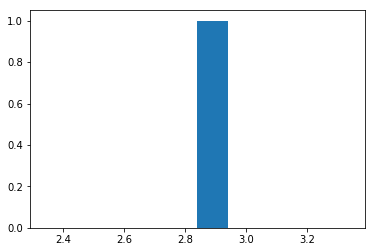

In [9]:
plt.hist(success_times)
plt.show()

In [10]:
print(len(femtimess))
#print(femtimess)
fts = [item for sublist in femtimess for item in sublist]
print(len(fts))

4
6


In [11]:
print(len(discards))

3


In [12]:
fitness_states

[0, 0, 0, 1]

In [13]:
print(discards)

[{'tau': 0.09169821482847042, 'time': 0.19729462593013772, 'owner': 3, 'action': -2, 'target': 3}, {'tau': 0.004910463758239914, 'time': 0.27408498343579285, 'owner': 2, 'action': -4, 'target': 1}, {'tau': 0.030121345077990684, 'time': 3.3293942611694805, 'owner': 3, 'action': -2, 'target': 3}]
